In [1]:
import pandas as pd
import numpy as np

In [2]:
import gzip

In [3]:
from collections import Counter

In [4]:
pd.set_option('display.max_rows',500)

In [5]:
from tqdm.notebook import tqdm

In [6]:
import random
import numpy as np

In [7]:
catalysis = []
reaction = []

In [25]:
stitch_data = pd.read_csv('./raw_data/stitch_selected_rows.csv.gz')

In [10]:
entities_to_consider = set(stitch_data['item_id_a'].unique()).union(stitch_data['item_id_b'].unique())

In [11]:
from covid.datasets import StitchDataset

In [13]:
proteins_with_sequences = set()
current_name = None
current_sequence = ''
p_cnt = 0

with gzip.open("./raw_data/protein.sequences.v9.1.fa.gz", "rt") as f:
    for line in tqdm(f):
        if line.startswith(">"):
            if current_name is not None and current_name in entities_to_consider:
                proteins_with_sequences.add(current_name)
            current_name = line.split(" (")[0][1:]
            current_sequence = ''
            p_cnt += 1
        else:
            current_sequence += line.strip()
            
if current_name in entities_to_consider:        
    proteins_with_sequences.add(current_name)

In [14]:
chemicals_with_details = set()

for chunk_idx, chunk in tqdm(enumerate(pd.read_csv("./raw_data/chemicals.v5.0.tsv.gz", sep='\t', chunksize=1000))):
    chemicals_with_details.update(entities_to_consider.intersection(chunk['chemical'].values))

In [15]:
len(chemicals_with_details)

9373

In [26]:
stitch_data = stitch_data.loc[
    (
        (stitch_data['item_id_a'].isin(proteins_with_sequences) | stitch_data['item_id_a'].isin(chemicals_with_details))
        & (stitch_data['item_id_b'].isin(proteins_with_sequences) | stitch_data['item_id_b'].isin(chemicals_with_details))
    )
]

In [28]:
stitch_data['mode'].value_counts()

binding       1289138
reaction       309958
inhibition     266560
activation     140843
catalysis      116415
Name: mode, dtype: int64

In [29]:
np.random.seed(4)
num_inhibitions = stitch_data['mode'].value_counts()['inhibition']

stitch_data = stitch_data.groupby('mode').apply(
    lambda x: x.sample(n=min(x.shape[0], num_inhibitions))
).reset_index(drop=True)

In [30]:
all_entities = stitch_data['item_id_a'].append(stitch_data['item_id_b'].rename('item_id_a'))

In [31]:
all_chemicals = set(all_entities.loc[all_entities.str.startswith('CID')].unique())
all_proteins = set(all_entities.loc[~all_entities.str.startswith('CID')].unique())

In [32]:
selected_paths = list(set(stitch_data[['item_id_a', 'item_id_b']].itertuples(name=None, index=False)))

In [33]:
selected_modes = stitch_data['mode'].unique()

In [34]:
idx_lookup = set([x + "::" + y for x,y in selected_paths])

In [ ]:
# result = pd.Series(
#     np.nan, 
#     index=pd.MultiIndex.from_tuples(
#         (x + (y,) for x in selected_paths for y in selected_modes),
#         names=['item_id_a', 'item_id_b', 'mode']
#     )
# )
# idx_lookup = set(result.index)

all_results = []

for chunk in tqdm(pd.read_csv('./raw_data/actions.v5.0.tsv.gz', sep='\t', chunksize=1000000)):
    chunk = chunk.loc[chunk['mode'].isin(selected_modes)].copy()
    
    chunk_ab = chunk.loc[~chunk['item_id_b'].str.startswith("CID")]
    key = chunk_ab['item_id_a'] + "::" + chunk_ab['item_id_b']
    chunk_ab = chunk_ab.loc[key.isin(idx_lookup)]
    
    chunk_ba = chunk.loc[
        (chunk['a_is_acting'] == 'f')
        & ~chunk['item_id_a'].str.startswith("CID")
    ].rename({
        'item_id_b':'tmp_a', 'item_id_a':'tmp_b'
    }, axis=1).rename({
        'tmp_a':'item_id_a', 'tmp_b':'item_id_b'
    }, axis=1)
    key = chunk_ba['item_id_a'] + "::" + chunk_ba['item_id_b']
    chunk_ba = chunk_ba.loc[key.isin(idx_lookup)]
    
    if chunk_ab.shape[0] > 0:
        all_results.append(chunk_ab)
        
    if chunk_ba.shape[0] > 0:
        all_results.append(chunk_ba)
        

In [ ]:
final_output = pd.pivot_table(
    pd.concat(all_results, 0, sort=False), 
    index=['item_id_a', 'item_id_b'], 
    columns=['mode']
)

final_output.sample(25)

In [ ]:
final_output.columns = final_output.columns.droplevel(0)

In [ ]:
all_entities = final_output.index.get_level_values(0).append(final_output.index.get_level_values(1))

In [ ]:
assert (all_entities.isin(all_proteins) | all_entities.isin(all_chemicals)).all(), "The fuck?!"

In [33]:
len(all_proteins)

65022

In [34]:
protein_lookup = {}
current_name = None
current_sequence = ''
p_cnt = 0

with gzip.open("protein.sequences.v9.1.fa.gz", "rt") as f:
    for line in tqdm(f):
        if line.startswith(">"):
            if current_name is not None and current_name in all_proteins:
                protein_lookup[current_name] = current_sequence
            current_name = line.split(" (")[0][1:]
            current_sequence = ''
            p_cnt += 1
        else:
            current_sequence += line.strip()
            
if current_sequence != '' and current_name in all_proteins:
    protein_lookup[current_name] = current_sequence

In [52]:
(final_output.index.get_level_values(1).isin(protein_lookup) | final_output.index.get_level_values(1).isin(chemical_lookup))

1.0

0.999466578549849

In [42]:
import rdkit, chemprop
import argparse
def create_chemprop_args():
    args = argparse.Namespace()
    args.seed = 0
    args.ensemble_size = 1
    args.hidden_size = 300
    args.bias = False
    args.depth = 3
    args.dropout = 0.0
    args.activation = 'ReLU'
    args.undirected = False
    args.atom_messages = False
    
    return args

In [43]:
args = create_chemprop_args()

In [9]:
import numpy as np

In [16]:
print('\n'.join(''.join(np.random.choice(list("0123456789"),5)) for _ in range(22)))

28964
38401
31349
45477
26182
99572
81807
01775
91875
23703
45125
31520
40700
33725
22953
93941
96687
67337
06167
39290
21757
19809


In [45]:
from rdkit.Chem import Descriptors as rdkDesc
from rdkit.Chem import AllChem as rdkAC

features = [
    (rdkDesc, 'BalabanJ'),
    (rdkDesc, 'BertzCT'),
    (rdkDesc, 'Chi0'),
    (rdkDesc, 'Chi0n'),
    (rdkDesc, 'Chi0v'),
    (rdkDesc, 'Chi1'),
    (rdkDesc, 'Chi1n'),
    (rdkDesc, 'Chi1v'),
    (rdkDesc, 'Chi2n'),
    (rdkDesc, 'Chi2v'),
    (rdkDesc, 'Chi3n'),
    (rdkDesc, 'Chi3v'),
    (rdkDesc, 'Chi4n'),
    (rdkDesc, 'Chi4v'),
    (rdkDesc, 'EState_VSA1'),
    (rdkDesc, 'EState_VSA2'),
    (rdkDesc, 'EState_VSA3'),
    (rdkDesc, 'EState_VSA4'),
    (rdkDesc, 'EState_VSA5'),
    (rdkDesc, 'EState_VSA6'),
    (rdkDesc, 'EState_VSA7'),
    (rdkDesc, 'EState_VSA8'),
    (rdkDesc, 'EState_VSA9'),
    (rdkDesc, 'EState_VSA10'),
    (rdkDesc, 'EState_VSA11'),
    (rdkDesc, 'ExactMolWt'),
    (rdkDesc, 'FpDensityMorgan1'),
    (rdkDesc, 'FpDensityMorgan2'),
    (rdkDesc, 'FpDensityMorgan3'),
    (rdkDesc, 'FractionCSP3'),
    (rdkDesc, 'HallKierAlpha'),
    (rdkDesc, 'HeavyAtomCount'),
    (rdkDesc, 'HeavyAtomMolWt'),
    (rdkDesc, 'Ipc'),
    (rdkDesc, 'Kappa1'),
    (rdkDesc, 'Kappa2'),
    (rdkDesc, 'Kappa3'),
    (rdkDesc, 'LabuteASA'),
    (rdkDesc, 'MaxAbsEStateIndex'),
    (rdkDesc, 'MaxAbsPartialCharge'),
    (rdkDesc, 'MaxEStateIndex'),
    (rdkDesc, 'MaxPartialCharge'),
    (rdkDesc, 'MinAbsEStateIndex'),
    (rdkDesc, 'MinAbsPartialCharge'),
    (rdkDesc, 'MinEStateIndex'),
    (rdkDesc, 'MinPartialCharge'),
    (rdkDesc, 'MolLogP'),
    (rdkDesc, 'MolMR'),
    (rdkDesc, 'MolWt'),
    (rdkDesc, 'NHOHCount'),
    (rdkDesc, 'NOCount'),
    (rdkDesc, 'NumAliphaticCarbocycles'),
    (rdkDesc, 'NumAliphaticHeterocycles'),
    (rdkDesc, 'NumAliphaticRings'),
    (rdkAC, 'CalcNumAmideBonds'),
    (rdkDesc, 'NumAromaticCarbocycles'),
    (rdkDesc, 'NumAromaticHeterocycles'),
    (rdkDesc, 'NumAromaticRings'),
    (rdkAC, 'CalcNumAtomStereoCenters'),
    (rdkAC, 'CalcNumBridgeheadAtoms'),
    (rdkAC, 'CalcNumHBA'),
    (rdkAC, 'CalcNumHBD'),
    (rdkDesc, 'NumHeteroatoms'),
    (rdkAC, 'CalcNumHeterocycles'),
    (rdkAC, 'CalcNumLipinskiHBA'),
    (rdkAC, 'CalcNumLipinskiHBD'),
    (rdkAC, 'CalcNumRings'),
    (rdkAC, 'CalcNumRotatableBonds'),
    (rdkAC, 'CalcNumSaturatedCarbocycles'),
    (rdkAC, 'CalcNumSaturatedHeterocycles'),
    (rdkAC, 'CalcNumSaturatedRings'),
    (rdkAC, 'CalcNumSpiroAtoms'),
    (rdkAC, 'CalcNumUnspecifiedAtomStereoCenters'),
    (rdkDesc, 'NumHAcceptors'),
    (rdkDesc, 'NumHDonors'),
    (rdkDesc, 'NumRadicalElectrons'),
    (rdkDesc, 'NumValenceElectrons'),
    (rdkDesc, 'PEOE_VSA1'),
    (rdkDesc, 'PEOE_VSA2'),
    (rdkDesc, 'PEOE_VSA3'),
    (rdkDesc, 'PEOE_VSA4'),
    (rdkDesc, 'PEOE_VSA5'),
    (rdkDesc, 'PEOE_VSA6'),
    (rdkDesc, 'PEOE_VSA7'),
    (rdkDesc, 'PEOE_VSA8'),
    (rdkDesc, 'PEOE_VSA9'),
    (rdkDesc, 'PEOE_VSA10'),
    (rdkDesc, 'PEOE_VSA11'),
    (rdkDesc, 'PEOE_VSA12'),
    (rdkDesc, 'PEOE_VSA13'),
    (rdkDesc, 'PEOE_VSA14'),
    (rdkDesc, 'RingCount'),
    (rdkDesc, 'SMR_VSA1'),
    (rdkDesc, 'SMR_VSA2'),
    (rdkDesc, 'SMR_VSA3'),
    (rdkDesc, 'SMR_VSA4'),
    (rdkDesc, 'SMR_VSA5'),
    (rdkDesc, 'SMR_VSA6'),
    (rdkDesc, 'SMR_VSA7'),
    (rdkDesc, 'SMR_VSA8'),
    (rdkDesc, 'SMR_VSA9'),
    (rdkDesc, 'SMR_VSA10'),
    (rdkDesc, 'SlogP_VSA1'),
    (rdkDesc, 'SlogP_VSA2'),
    (rdkDesc, 'SlogP_VSA3'),
    (rdkDesc, 'SlogP_VSA4'),
    (rdkDesc, 'SlogP_VSA5'),
    (rdkDesc, 'SlogP_VSA6'),
    (rdkDesc, 'SlogP_VSA7'),
    (rdkDesc, 'SlogP_VSA8'),
    (rdkDesc, 'SlogP_VSA9'),
    (rdkDesc, 'SlogP_VSA10'),
    (rdkDesc, 'SlogP_VSA11'),
    (rdkDesc, 'SlogP_VSA12'),
    (rdkDesc, 'TPSA'),
    (rdkDesc, 'VSA_EState1'),
    (rdkDesc, 'VSA_EState2'),
    (rdkDesc, 'VSA_EState3'),
    (rdkDesc, 'VSA_EState4'),
    (rdkDesc, 'VSA_EState5'),
    (rdkDesc, 'VSA_EState6'),
    (rdkDesc, 'VSA_EState7'),
    (rdkDesc, 'VSA_EState8'),
    (rdkDesc, 'VSA_EState9'),
    (rdkDesc, 'VSA_EState10'),
    (rdkDesc, 'fr_Al_COO'),
    (rdkDesc, 'fr_Al_OH'),
    (rdkDesc, 'fr_Al_OH_noTert'), # fr_Al_OH_noTert
    (rdkDesc, 'fr_ArN'), # fr_ArN
    (rdkDesc, 'fr_Ar_COO'), # fr_Ar_COO
    (rdkDesc, 'fr_Ar_N'), # fr_Ar_N
    (rdkDesc, 'fr_Ar_NH'), # fr_Ar_NH
    (rdkDesc, 'fr_Ar_OH'), # fr_Ar_OH
    (rdkDesc, 'fr_COO'), # fr_COO
    (rdkDesc, 'fr_COO2'), # fr_COO2
    (rdkDesc, 'fr_C_O'), # fr_C_O
    (rdkDesc, 'fr_C_O_noCOO'), # fr_C_O_noCOO
    (rdkDesc, 'fr_C_S'), # fr_C_S
    (rdkDesc, 'fr_HOCCN'),
    (rdkDesc, 'fr_Imine'),
    (rdkDesc, 'fr_NH0'),
    (rdkDesc, 'fr_NH1'),
    (rdkDesc, 'fr_NH2'),
    (rdkDesc, 'fr_N_O'),
    (rdkDesc, 'fr_Ndealkylation1'),
    (rdkDesc, 'fr_Ndealkylation2'),
    (rdkDesc, 'fr_Nhpyrrole'),
    (rdkDesc, 'fr_SH'),
    (rdkDesc, 'fr_aldehyde'),
    (rdkDesc, 'fr_alkyl_carbamate'),
    (rdkDesc, 'fr_alkyl_halide'),
    (rdkDesc, 'fr_allylic_oxid'),
    (rdkDesc, 'fr_amide'),
    (rdkDesc, 'fr_amidine'),
    (rdkDesc, 'fr_aniline'),
    (rdkDesc, 'fr_aryl_methyl'),
    (rdkDesc, 'fr_azide'),
    (rdkDesc, 'fr_azo'),
    (rdkDesc, 'fr_barbitur'),
    (rdkDesc, 'fr_benzene'),
    (rdkDesc, 'fr_benzodiazepine'),
    (rdkDesc, 'fr_bicyclic'),
    (rdkDesc, 'fr_diazo'),
    (rdkDesc, 'fr_dihydropyridine'),
    (rdkDesc, 'fr_epoxide'),
    (rdkDesc, 'fr_ester'),
    (rdkDesc, 'fr_ether'),
    (rdkDesc, 'fr_furan'),
    (rdkDesc, 'fr_guanido'),
    (rdkDesc, 'fr_halogen'),
    (rdkDesc, 'fr_hdrzine'),
    (rdkDesc, 'fr_hdrzone'),
    (rdkDesc, 'fr_imidazole'),
    (rdkDesc, 'fr_imide'),
    (rdkDesc, 'fr_isocyan'),
    (rdkDesc, 'fr_isothiocyan'),
    (rdkDesc, 'fr_ketone'),
    (rdkDesc, 'fr_ketone_Topliss'),
    (rdkDesc, 'fr_lactam'),
    (rdkDesc, 'fr_lactone'),
    (rdkDesc, 'fr_methoxy'),
    (rdkDesc, 'fr_morpholine'),
    (rdkDesc, 'fr_nitrile'),
    (rdkDesc, 'fr_nitro'),
    (rdkDesc, 'fr_nitro_arom'),
    (rdkDesc, 'fr_nitro_arom_nonortho'),
    (rdkDesc, 'fr_nitroso'),
    (rdkDesc, 'fr_oxazole'),
    (rdkDesc, 'fr_oxime'),
    (rdkDesc, 'fr_para_hydroxylation'),
    (rdkDesc, 'fr_phenol'),
    (rdkDesc, 'fr_phenol_noOrthoHbond'),
    (rdkDesc, 'fr_phos_acid'),
    (rdkDesc, 'fr_phos_ester'),
    (rdkDesc, 'fr_piperdine'),
    (rdkDesc, 'fr_piperzine'),
    (rdkDesc, 'fr_priamide'),
    (rdkDesc, 'fr_prisulfonamd'),
    (rdkDesc, 'fr_pyridine'),
    (rdkDesc, 'fr_quatN'),
    (rdkDesc, 'fr_sulfide'),
    (rdkDesc, 'fr_sulfonamd'),
    (rdkDesc, 'fr_sulfone'),
    (rdkDesc, 'fr_term_acetylene'),
    (rdkDesc, 'fr_tetrazole'),
    (rdkDesc, 'fr_thiazole'),
    (rdkDesc, 'fr_thiocyan'),
    (rdkDesc, 'fr_thiophene'),
    (rdkDesc, 'fr_unbrch_alkane'),
    (rdkDesc, 'fr_urea'),
    (rdkDesc, 'qed')
    
]

features = [(getattr(mod, name), name[4:] if name.startswith('Calc') else name) for mod, name in features]
feature_calcs, feature_names = zip(*features)

print(len(features))

211


In [48]:
chemical_lookup = {}
num_processed = 0

for chunk_idx, chunk in tqdm(enumerate(pd.read_csv("chemicals.v5.0.tsv.gz", sep='\t', chunksize=1000))):
    this_new = 0
    this_processed = 0

    for _, row in chunk.iterrows():
        num_processed += 1
        this_processed += 1
        if row['chemical'] in all_chemicals:
            mol = rdkit.Chem.MolFromSmiles(row['SMILES_string'])
            if mol is None:
                continue

            molgraph = chemprop.features.featurization.MolGraph(row['SMILES_string'], args)
            if molgraph is None:
                continue

            try:
                chemical_lookup[row['chemical']] = (
                    row['chemical'],
                    row['name'],
                    row['molecular_weight'],
                    row['SMILES_string'],
                    molgraph,
                    [calc(mol) for calc in feature_calcs]
                )

                this_new += 1
            except Exception as ex:
                print(f"Could not preprocess molecule \"{row['name']}\" ({row['SMILES_string']}) -- {ex}")
    print(f"{len(chemical_lookup)/num_processed:0.1%} of chemicals have been new, {this_new/this_processed:0.1%} this chunk    ", end='\r')

Could not preprocess molecule "hydrogen" ([HH]) -- float division by zero
Could not preprocess molecule "hydrogen" ([HH]) -- float division by zero
0.0% of chemicals have been new, 0.0% this chunk     


In [54]:
print("Portion retained", (
    (final_output.index.get_level_values(0).isin(protein_lookup) | final_output.index.get_level_values(0).isin(chemical_lookup))
    & (final_output.index.get_level_values(1).isin(protein_lookup) | final_output.index.get_level_values(1).isin(chemical_lookup))
).mean())

Portion retained 0.999466578549849


In [55]:
final_output = final_output.loc[(
    (final_output.index.get_level_values(0).isin(protein_lookup) | final_output.index.get_level_values(0).isin(chemical_lookup))
    & (final_output.index.get_level_values(1).isin(protein_lookup) | final_output.index.get_level_values(1).isin(chemical_lookup))
)]

In [57]:
final_output.to_csv('data/stitch_preprocessed.csv.gz', index=True)

In [59]:
import pickle as pkl

In [60]:
with gzip.open('data/stitch_proteins.pkl.gz', 'wb') as f:
    pkl.dump(protein_lookup, f, pkl.HIGHEST_PROTOCOL)

with gzip.open('data/stitch_chemicals.pkl.gz', 'wb') as f:
    pkl.dump(chemical_lookup, f, pkl.HIGHEST_PROTOCOL)

In [49]:
len(chemical_lookup)

7350

In [ ]:
chemprop

In [11]:
import pickle as pkl

In [18]:
import chemprop

In [21]:
Namespace()

Namespace()

In [27]:
args = create_chemprop_args()

In [28]:
chemprop.features.featurization.MolGraph('C(C(C(C1=NC2=C(NC(=NC2=O)N)N(C1O)O)O)O)OP(=O)(O)OP(=O)(O)OP(=O)(O)O', args)

In [32]:
import torch as T

In [35]:
smiles_seen = {}
num_processed = 0

for chunk_idx, chunk in tqdm(enumerate(pd.read_csv("chemicals.v5.0.tsv.gz", sep='\t', chunksize=1000))):
    
    if chunk_idx <= 7288:
        for _, row in chunk.iterrows():
            num_processed += 1
            if row['SMILES_string'] not in smiles_seen:
                smiles_seen[row['SMILES_string']] = row['chemical']
        continue
    
    this_new = 0
    this_processed = 0
    
    with gzip.open(f'./preprocessed_chemicals/{chunk_idx:04}.pkl.gz', 'wb') as f:
        for _, row in chunk.iterrows():
            num_processed += 1
            this_processed += 1
            if row['SMILES_string'] in smiles_seen:
                pkl.dump((row['chemical'], 'ALIAS', row['name'], smiles_seen[row['SMILES_string']]), f, pkl.HIGHEST_PROTOCOL)
            else:
                mol = rdkit.Chem.MolFromSmiles(row['SMILES_string'])
                if mol is None:
                    continue

                molgraph = chemprop.features.featurization.MolGraph(row['SMILES_string'], args)
                if molgraph is None:
                    continue
                    
                try:
                    pkl.dump((
                        row['chemical'],
                        'NEW',
                        row['name'],
                        row['molecular_weight'],
                        row['SMILES_string'],
                        molgraph,
                        [calc(mol) for calc in feature_calcs]
                    ), f, pkl.HIGHEST_PROTOCOL)
                    
                    smiles_seen[row['SMILES_string']] = row['chemical']
                    this_new += 1
                except Exception as ex:
                    print(f"Could not preprocess molecule \"{row['name']}\" ({row['SMILES_string']}) -- {ex}")
    print(f"{len(smiles_seen)/num_processed:0.1%} of chemicals have been new, {this_new/this_processed:0.1%} this chunk    ", end='\r')

In [ ]:
mol = rdkit.Chem.MolFromSmiles('C(C(C(C1=NC2=C(NC(=NC2=O)N)N(C1O)O)O)O)OP(=O)(O)OP(=O)(O)OP(=O)(O)O')

In [2]:
import pandas as pd

In [5]:
from matplotlib import pyplot as plt

In [8]:
stitch_data.groupby('mode')['score'].count()

mode
activation     334021
binding       3223009
catalysis      263143
inhibition     750830
reaction       475884
Name: score, dtype: int64

In [118]:
rdkit.Chem.Descriptors.Chi0(mol)

24.645899891012462

In [ ]:
p_res = pd.read_csv('actions_through_5330000000.csv')

In [14]:
p_res['mode'].value_counts()

binding       950605
reaction      259219
inhibition    246385
activation    145053
catalysis       3516
Name: mode, dtype: int64

In [59]:
mode_ctr

Counter({'binding': 40817218,
         'pred_bind': 1049736,
         'inhibition': 3439488,
         'activation': 1442687,
         'reaction': 714075,
         'catalysis': 507387,
         'expression': 21362})

In [74]:
(catalysis['score']>=885.0).mean()

0.00039417643731510664

In [79]:
catalysis['score'].min()

150

In [78]:
(reaction['score'] >= 954).mean() * 1.4

0.0004372089766481112

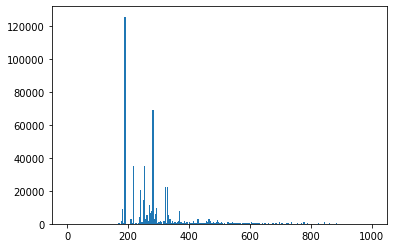

In [44]:
plt.hist(catalysis['score'], bins=250, range=(0,1000));

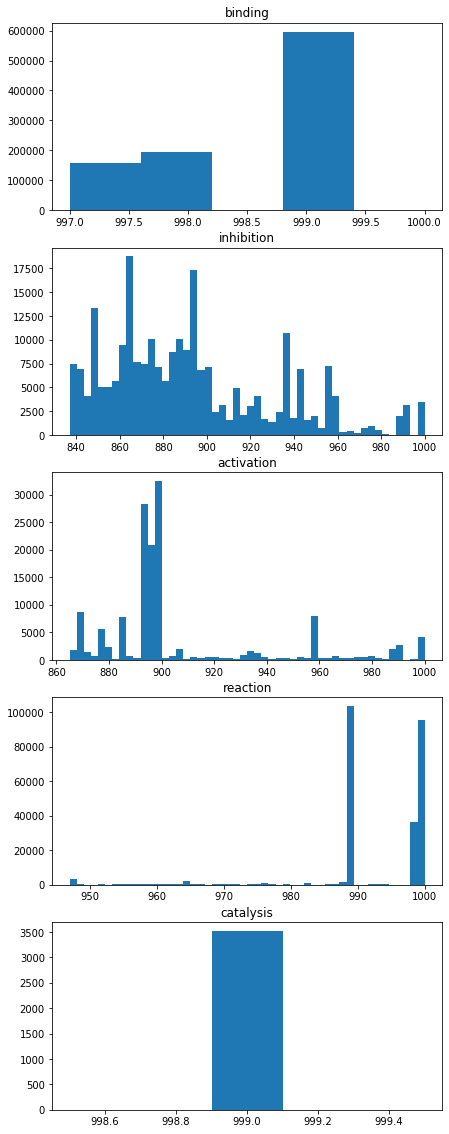

In [39]:
fig, axes = plt.subplots(nrows=5, figsize=(7,20))
for mode, ax in zip(p_res['mode'].unique(), axes):
    data = p_res.loc[p_res['mode'] == mode]
    ax.hist(data['score'], bins=min(50, max(5,int(1000-data['score'].min()+1))))
    ax.set_title(mode)

In [34]:
axes[4]